# PyClassyFire Tutorial: Classifying Chemical Compounds Using the ClassyFire API


## Introduction

Welcome to the **PyClassyFire** tutorial! This guide will walk you through the process of classifying a large set of chemical compounds using the [ClassyFire](http://classyfire.wishartlab.com/) API. We'll utilize the `PyClassyFire` package, which provides a command-line interface (CLI) and programmatic access to the ClassyFire service, enabling efficient and scalable classification of chemical structures.

By the end of this tutorial, you'll be able to:

1. **Preprocess your SMILES data**: Prepare your unique SMILES strings for classification.
2. **Submit classification jobs**: Use the `PyClassyFire` package to send your data to the ClassyFire API.
3. **Retrieve and process results**: Collect the classification results and merge them with your original data.
4. **Save the annotated data**: Store the enriched dataset for further analysis.

Let's get started!

## Prerequisites

Before diving into the tutorial, ensure you have the following:

- **Conda Environment**: A Conda environment named `classyfire_env` with all necessary dependencies installed.
- **PyClassyFire Package**: Installed and accessible within your Conda environment.
- **Unique SMILES Data**: A TSV file containing approximately 16,000 unique SMILES strings located at `/Users/macbook/CODE/PyClassyFire/data/unique_valid_smiles_no_header.tsv`.

**Note:** This tutorial assumes that the Conda environment and `PyClassyFire` package are already set up. If not, please refer to the [repository's README](https://github.com/Jozefov/PyClassyFire) for setup instructions.




In [1]:
import os
import pandas as pd
import json


from pyclassyfire.src.utils import MoleCule, load_existing_results, save_intermediate_results, merge_intermediate_files, check_all_smiles_present
from pyclassyfire.src.batch import process_batches_with_saving_and_retry

NameError: name 'Set' is not defined

In [5]:
# Define paths
smiles_file_path = '../data/unique_valid_smiles_no_header.tsv'
output_dir = '../data/original_smiles_match/'
final_output_path = '../data/original_smiles_match/final_classification_results.json'

In [6]:
# Load SMILES data
smiles_df = pd.read_csv(smiles_file_path, sep='\t', header=None, names=['SMILES']).dropna()

# Canonicalize SMILES
smiles_df['Canonical_SMILES'] = smiles_df['SMILES'].apply(
    lambda x: MoleCule.from_smiles(x).canonical_smiles if x else None
).dropna()

In [7]:
# Remove invalid entries
invalid_smiles = smiles_df['Canonical_SMILES'].isnull().sum()
print(f"Number of invalid SMILES after canonicalization: {invalid_smiles}")

if invalid_smiles > 0:
    smiles_df = smiles_df.dropna(subset=['Canonical_SMILES'])
    print(f"Removed {invalid_smiles} invalid SMILES entries.")

Number of invalid SMILES after canonicalization: 0


In [8]:
# Reset index after cleaning
smiles_df.reset_index(drop=True, inplace=True)

# Extract the list of canonical SMILES
canonical_smiles_list = smiles_df['Canonical_SMILES'].tolist()
canonical_smiles_list = list(set(canonical_smiles_list))

# Extract the list of original SMILES
original_smiles_list = smiles_df['SMILES'].tolist()
original_smiles_list = list(set(original_smiles_list))

In [9]:
# Define parameters
batch_size = 100          # Number of SMILES per job
output_dir = '../data/original_smiles_match/'
max_retries = 1           # Maximum number of retries for failed batches
retry_delay = 10         # Delay between retries in seconds 

In [10]:
# Process the batches with resumption and retry logic
intermediate_files = process_batches_with_saving_and_retry(
    smiles_list=canonical_smiles_list,
    batch_size=batch_size,
    output_dir=output_dir,
    max_retries=max_retries,
    retry_delay=retry_delay
)

2025-01-08 08:52:10,029 - INFO - All SMILES: 13685
2025-01-08 08:52:10,030 - INFO - Already processed SMILES: 0
2025-01-08 08:52:10,031 - INFO - Remaining SMILES to process: 13685
2025-01-08 08:52:10,032 - INFO - Remaining unique SMILES to process after removing duplicates: 13685
2025-01-08 08:52:10,033 - INFO - Total remaining batches to process: 137


All  smiles: 13685
Already processed SMILES: 0
Remaining SMILES to process: 13685
Remaining unique SMILES to process after removing duplicates: 13685
Total remaining batches to process: 137


Processing Batches:   0%|          | 0/137 [00:00<?, ?it/s]2025-01-08 08:52:11,623 - INFO - Submitted Batch 1 with Query ID 12024128


Submitted Batch 1 with Query ID 12024128


KeyboardInterrupt: 

In [9]:
# Merge the intermediate files into the final JSON
merge_intermediate_files(output_dir, final_output_path)

Successfully merged 213 files into ../data/final_classification_results.json.


In [10]:
# Check if all SMILES are present in the final output
missing_smiles_mapping = check_all_smiles_present(final_output_path, original_smiles_list)

Missing 541 SMILES in the final output:
Can be caused by server ERROR, try to lower batch and rerun.
It keeps already processed molecules and will try to retrieve only missing smiles.


In [11]:
if missing_smiles_mapping:
    missing_smiles_path = os.path.join("../data/", 'missing_smiles.json')
    try:
        with open(missing_smiles_path, 'w') as f:
            json.dump(missing_smiles_mapping, f, indent=4)
    except Exception as e:
        print(f"Error saving missing SMILES mapping: {e}")
else:
    print("No missing SMILES. All SMILES have been successfully processed.")

In [35]:
missing_smiles = list(missing_smiles_mapping.values())[:100]

In [36]:
df_unique = pd.DataFrame({
    'SMILES': missing_smiles 
})

In [37]:
output_file_missing = '/Users/macbook/CODE/PyClassyFire/data/isomers_cannonized.tsv'
df_unique.to_csv(output_file_missing, sep='\t', index=False)

# **TODO**

## IT all works, however for some challenging molecules we could not match, I contacted developers and will update accordingly  

# Analyze discrepancy

In [5]:
import pandas as pd
import json

# Paths to the TSV files
original_smiles_tsv = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles.tsv'
canonical_smiles_tsv = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles_cannonized.tsv'

# Load the original and canonical SMILES
df_original = pd.read_csv(original_smiles_tsv, sep='\t', header=None, names=['Original_SMILES'])
df_canonical = pd.read_csv(canonical_smiles_tsv, sep='\t', header=None, names=['Canonical_SMILES'])

# Load JSON files
def load_smiles_from_json(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        # Assuming each entry has a 'smiles' field
        data = data["entities"]
        smiles = [entry['smiles'] for entry in data if 'smiles' in entry]
        return smiles
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return []

json_original = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles.json'
json_canonical = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles_cannonized.json'

smiles_web_original = load_smiles_from_json(json_original)
smiles_web_canonical = load_smiles_from_json(json_canonical)

df_web_original = pd.DataFrame({'Web_SMILES': smiles_web_original})
df_web_canonical = pd.DataFrame({'Web_Canonical_SMILES': smiles_web_canonical})

# Combine all DataFrames into one comprehensive DataFrame
df_mapping = pd.concat([df_original, df_canonical], axis=1).reset_index(drop=True)

# Ensure both Web_SMILES and Web_Canonical_SMILES are aligned correctly
df_full = pd.concat([df_mapping, df_web_original, df_web_canonical], axis=1)

# Verify the merged DataFrame
print("\nCombined DataFrame Sample:")
print(df_full.head())


Combined DataFrame Sample:
                                     Original_SMILES  \
0                                             SMILES   
1  CC(C)C[C@@H](C(=O)O)NC(=O)N1CCC2=CC(=C(C=C2C1)...   
2  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](...   
3  CCCC1=CC(=O)OC2=C1C=CC(=C2C)OC(C)C(=O)N[C@@H](...   
4                C1C2=C(C=CC(=C2Cl)Cl)N=C3N1CC(=O)N3   

                                    Canonical_SMILES  \
0                                             SMILES   
1        COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2   
2  CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc...   
3  CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=...   
4                     O=C1CN2Cc3c(ccc(Cl)c3Cl)N=C2N1   

                                          Web_SMILES  \
0  [H]N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([...   
1  [H][C@@](CC(C)C)(N=C(O)N1CCC2=CC(OC)=C(OC)C=C2...   
2  [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C...   
3  [H]C(C)(OC1=C(C)C2=C(C=C1)C(CCC)=CC(=O)O2)C(O)...   
4                O

In [6]:
# Function to identify mismatches
def identify_mismatches(df, original_col, web_col):
    """
    Identifies mismatches between original and web SMILES.
    
    Parameters:
    - df (DataFrame): DataFrame containing SMILES columns.
    - original_col (str): Column name for original SMILES.
    - web_col (str): Column name for web SMILES.
    
    Returns:
    - DataFrame: Rows where SMILES do not match.
    """
    mismatch = df[df[original_col] != df[web_col]]
    return mismatch

# Identify mismatches in Original SMILES
mismatches_original = identify_mismatches(df_full, 'Original_SMILES', 'Web_SMILES')

print(f"\nNumber of Mismatches in Original SMILES: {mismatches_original.shape[0]}")
print("Sample of Mismatches in Original SMILES:")
print(mismatches_original[['Original_SMILES', 'Web_SMILES']].head())

# Identify mismatches in Canonical SMILES
mismatches_canonical = identify_mismatches(df_full, 'Canonical_SMILES', 'Web_Canonical_SMILES')

print(f"\nNumber of Mismatches in Canonical SMILES: {mismatches_canonical.shape[0]}")
print("Sample of Mismatches in Canonical SMILES:")
print(mismatches_canonical[['Canonical_SMILES', 'Web_Canonical_SMILES']].head())


Number of Mismatches in Original SMILES: 101
Sample of Mismatches in Original SMILES:
                                     Original_SMILES  \
0                                             SMILES   
1  CC(C)C[C@@H](C(=O)O)NC(=O)N1CCC2=CC(=C(C=C2C1)...   
2  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](...   
3  CCCC1=CC(=O)OC2=C1C=CC(=C2C)OC(C)C(=O)N[C@@H](...   
4                C1C2=C(C=CC(=C2Cl)Cl)N=C3N1CC(=O)N3   

                                          Web_SMILES  
0  [H]N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([...  
1  [H][C@@](CC(C)C)(N=C(O)N1CCC2=CC(OC)=C(OC)C=C2...  
2  [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C...  
3  [H]C(C)(OC1=C(C)C2=C(C=C1)C(CCC)=CC(=O)O2)C(O)...  
4                OC1=NC2=NC3=C(CN2C1)C(Cl)=C(Cl)C=C3  

Number of Mismatches in Canonical SMILES: 100
Sample of Mismatches in Canonical SMILES:
                                    Canonical_SMILES  \
0                                             SMILES   
1        COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=

In [7]:
# Function to display detailed mismatch information
def display_mismatch_details(df, columns):
    """
    Displays detailed mismatch information for each row in the DataFrame.
    
    Parameters:
    - df (DataFrame): DataFrame containing mismatch rows.
    - columns (list): List of column names to display.
    """
    for index, row in df.iterrows():
        details = ""
        for col in columns:
            details += f"{col}: {row[col]}\n"
        print("\n" + details)

# Display details for mismatches in Original SMILES
if not mismatches_original.empty:
    print("\nDetails of Mismatches in Original SMILES:")
    display_mismatch_details(mismatches_original, ['Original_SMILES', 'Web_SMILES'])

# Display details for mismatches in Canonical SMILES
if not mismatches_canonical.empty:
    print("\nDetails of Mismatches in Canonical SMILES:")
    display_mismatch_details(mismatches_canonical, ['Canonical_SMILES', 'Web_Canonical_SMILES'])


Details of Mismatches in Original SMILES:

Original_SMILES: SMILES
Web_SMILES: [H]N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CO)C(O)=O


Original_SMILES: CC(C)C[C@@H](C(=O)O)NC(=O)N1CCC2=CC(=C(C=C2C1)OC)OC
Web_SMILES: [H][C@@](CC(C)C)(N=C(O)N1CCC2=CC(OC)=C(OC)C=C2C1)C(O)=O


Original_SMILES: CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](O3)(C(C)C)NC(=O)[C@H]4CN([C@@H]5CC6=C(NC7=CC=CC(=C67)C5=C4)Br)C)O
Web_SMILES: [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C@@](O[C@@]21O)(N=C(O)[C@@]1([H])CN(C)[C@]2([H])CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C


Original_SMILES: CCCC1=CC(=O)OC2=C1C=CC(=C2C)OC(C)C(=O)N[C@@H](CC3=CC=CC=C3)C(=O)O
Web_SMILES: [H]C(C)(OC1=C(C)C2=C(C=C1)C(CCC)=CC(=O)O2)C(O)=N[C@@]([H])(CC1=CC=CC=C1)C(O)=O


Original_SMILES: C1C2=C(C=CC(=C2Cl)Cl)N=C3N1CC(=O)N3
Web_SMILES: OC1=NC2=NC3=C(CN2C1)C(Cl)=C(Cl)C=C3


Original_SMILES: CCN=C1NC2=C(C=C(C=C2)Cl)C(O1)(C)C3=CC=CC=C3
Web_SMILES: CCNC1=Nc2ccc(Cl)cc2C(C)(O1)c1cccc


Original SMILES Visualization:


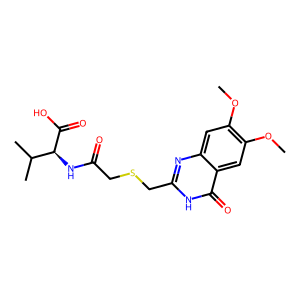


Web SMILES Visualization:


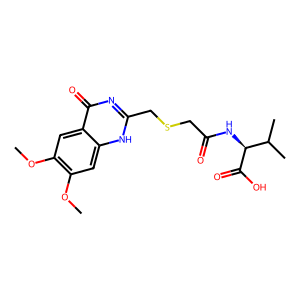

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw

# Function to visualize SMILES
def visualize_smiles(smiles, title="Molecule"):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Draw.MolToImage(mol, size=(300, 300))
    else:
        print(f"Invalid SMILES: {smiles}")
        return None

# Select a specific mismatch for visualization
specific_mismatch = mismatches_original.iloc[6]
original_smiles = specific_mismatch['Original_SMILES']
web_smiles = specific_mismatch['Web_SMILES']

print("\nOriginal SMILES Visualization:")
image_original = visualize_smiles(original_smiles, title="Original SMILES")
display(image_original)

print("\nWeb SMILES Visualization:")
image_web = visualize_smiles(web_smiles, title="Web SMILES")
display(image_web)

In [9]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

def standardize_smiles(smiles):
    """
    Standardizes SMILES by handling tautomerism, neutralizing charges, and standardizing aromaticity.
    
    Parameters:
    - smiles (str): The SMILES string to standardize.
    
    Returns:
    - str: The standardized canonical SMILES.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    # # Tautomer standardization
    # enumerator = rdMolStandardize.TautomerEnumerator()
    # mol = enumerator.Canonicalize(mol)
    # # Neutralize charges
    # uncharger = rdMolStandardize.Uncharger()
    # mol = uncharger.uncharge(mol)
    # # Aromaticity standardization
    # Chem.SanitizeMol(mol)
    # Generate standardized SMILES
    standardized_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    return standardized_smiles

In [10]:
# Apply standardization to original SMILES
df_original['Standardized_SMILES'] = df_original['Original_SMILES'].apply(standardize_smiles)

# Apply standardization to canonical SMILES
df_canonical['Standardized_Canonical_SMILES'] = df_canonical['Canonical_SMILES'].apply(standardize_smiles)

# Update the mapping DataFrame
df_mapping = pd.concat([df_original, df_canonical], axis=1).drop_duplicates().reset_index(drop=True)

In [11]:
# Function to standardize a list of SMILES
def standardize_smiles_list(smiles_list):
    return [standardize_smiles(smiles) for smiles in smiles_list]

# Apply standardization to Web SMILES
df_full['Web_SMILES_Standardized'] = standardize_smiles_list(df_full['Web_SMILES'])
df_full['Web_Canonical_SMILES_Standardized'] = standardize_smiles_list(df_full['Web_Canonical_SMILES'])

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t>> from this Python object of type float

In [43]:
# Identify mismatches in Original SMILES after standardization
mismatches_original = df_full[df_full['Standardized_SMILES'] != df_full['Web_SMILES_Standardized']]

print(f"\nNumber of Mismatches in Original SMILES after Standardization: {mismatches_original.shape[0]}")
print("Sample of Mismatches in Original SMILES after Standardization:")
print(mismatches_original[['Original_SMILES', 'Web_SMILES', 'Standardized_SMILES', 'Web_SMILES_Standardized']].head())

# Identify mismatches in Canonical SMILES after standardization
mismatches_canonical = df_full[df_full['Standardized_Canonical_SMILES'] != df_full['Web_Canonical_SMILES_Standardized']]

print(f"\nNumber of Mismatches in Canonical SMILES after Standardization: {mismatches_canonical.shape[0]}")
print("Sample of Mismatches in Canonical SMILES after Standardization:")
print(mismatches_canonical[['Canonical_SMILES', 'Web_Canonical_SMILES', 'Standardized_Canonical_SMILES', 'Web_Canonical_SMILES_Standardized']].head())

KeyError: 'Standardized_SMILES'

# FROM HERE

In [6]:
import pandas as pd
import json

# Paths to the TSV files
original_smiles_tsv = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles.tsv'
canonical_smiles_tsv = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles_cannonized.tsv'

# Load the original and canonical SMILES
df_original = pd.read_csv(original_smiles_tsv, sep='\t', header=None, names=['Original_SMILES'])
df_canonical = pd.read_csv(canonical_smiles_tsv, sep='\t', header=None, names=['Canonical_SMILES'])

# Load JSON files
def load_smiles_from_json(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        # Assuming each entry has a 'smiles' field
        data = data["entities"]
        smiles = [entry['smiles'] for entry in data if 'smiles' in entry]
        return smiles
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return []

json_original = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles.json'
json_canonical = '/Users/macbook/CODE/PyClassyFire/data/unique_smiles_cannonized.json'

smiles_web_original = load_smiles_from_json(json_original)
smiles_web_canonical = load_smiles_from_json(json_canonical)

df_web_original = pd.DataFrame({'Web_SMILES': smiles_web_original})
df_web_canonical = pd.DataFrame({'Web_Canonical_SMILES': smiles_web_canonical})

# Combine all DataFrames into one comprehensive DataFrame
df_mapping = pd.concat([df_original, df_canonical], axis=1).reset_index(drop=True)

# Ensure both Web_SMILES and Web_Canonical_SMILES are aligned correctly
df_full = pd.concat([df_mapping, df_web_original, df_web_canonical], axis=1)

# Verify the merged DataFrame
print("\nCombined DataFrame Sample:")
print(df_full.head())


Combined DataFrame Sample:
                                     Original_SMILES  \
0                                             SMILES   
1  CC(C)C[C@@H](C(=O)O)NC(=O)N1CCC2=CC(=C(C=C2C1)...   
2  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]3(N1C(=O)[C@](...   
3  CCCC1=CC(=O)OC2=C1C=CC(=C2C)OC(C)C(=O)N[C@@H](...   
4                C1C2=C(C=CC(=C2Cl)Cl)N=C3N1CC(=O)N3   

                                    Canonical_SMILES  \
0                                             SMILES   
1        COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2   
2  CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc...   
3  CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=...   
4                     O=C1CN2Cc3c(ccc(Cl)c3Cl)N=C2N1   

                                          Web_SMILES  \
0  [H]N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([...   
1  [H][C@@](CC(C)C)(N=C(O)N1CCC2=CC(OC)=C(OC)C=C2...   
2  [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C...   
3  [H]C(C)(OC1=C(C)C2=C(C=C1)C(CCC)=CC(=O)O2)C(O)...   
4                O

In [7]:
original_smiles = df_original["Original_SMILES"].tolist() 
canonical_smiles = df_canonical["Canonical_SMILES"].tolist()
web_smiles = df_web_original["Web_SMILES"].tolist() 
web_canonical_smiles = df_web_canonical["Web_Canonical_SMILES"].tolist() 

original_smiles = original_smiles[1::]
canonical_smiles = canonical_smiles[1::]

In [8]:
len(original_smiles), len(canonical_smiles), len(web_smiles), len(web_canonical_smiles)

(100, 100, 100, 100)

In [5]:
# original_smiles_canonized = []
# for smi in original_smiles:
#     canonical_smi = MoleCule.from_smiles(smi).canonical_smiles
#     original_smiles_canonized.append(canonical_smi)
# original_smiles_canonized_set = set(original_smiles_canonized)
# 
# canonical_smiles_canonized = []
# for smi in canonical_smiles:
#     canonical_smi = MoleCule.from_smiles(smi).canonical_smiles
#     canonical_smiles_canonized.append(canonical_smi)
# canonical_smiles_canonized_set = set(canonical_smiles_canonized)
# 
# web_smiles_canonized = []
# for smi in web_smiles:
#     canonical_smi = MoleCule.from_smiles(smi).canonical_smiles
#     web_smiles_canonized.append(canonical_smi)
# web_smiles_canonized_set = set(web_smiles_canonized)
# 
# web_canonical_smiles_canonized = []
# for smi in web_canonical_smiles:
#     canonical_smi = MoleCule.from_smiles(smi).canonical_smiles
#     web_canonical_smiles_canonized.append(canonical_smi)
# web_canonical_smiles_canonized_set = set(web_canonical_smiles_canonized)

In [6]:
# def canonize_smiles(smiles_list, source_name):
#     """
#     Canonicalize a list of SMILES strings with error handling.
# 
#     Parameters:
#     - smiles_list (list): List of SMILES strings to canonicalize.
#     - source_name (str): Name of the data source for error messages.
# 
#     Returns:
#     - list: Successfully canonicalized SMILES strings.
#     - list: Errors encountered as tuples (index, SMILES, error message).
#     """
#     canonized_list = []
#     errors = []
#     for idx, smi in enumerate(smiles_list, start=1):
#         try:
#             molecule = MoleCule.from_smiles(smi)
#             canonical_smi = molecule.canonical_smiles
#             canonized_list.append(canonical_smi)
#         except Exception as e:
#             print(f"Error processing SMILES at index {idx} in {source_name}: '{smi}' - {e}")
#             errors.append((idx, smi, str(e)))
#             continue  # Skip the problematic SMILES
#     return canonized_list, errors

In [7]:
# # Canonicalize original_smiles
# original_smiles_canonized, original_errors = canonize_smiles(original_smiles, "df_original")
# 
# # Canonicalize canonical_smiles
# canonical_smiles_canonized, canonical_errors = canonize_smiles(canonical_smiles, "df_canonical")
# 
# # Canonicalize web_smiles
# web_smiles_canonized, web_errors = canonize_smiles(web_smiles, "df_web_original")
# 
# # Canonicalize web_canonical_smiles
# web_canonical_smiles_canonized, web_canonical_errors = canonize_smiles(web_canonical_smiles, "df_web_canonical")
# 
# original_smiles_canonized_set = set(original_smiles_canonized)
# canonical_smiles_canonized_set = set(canonical_smiles_canonized)
# web_smiles_canonized_set = set(web_smiles_canonized)
# web_canonical_smiles_canonized_set = set(web_canonical_smiles_canonized)

In [8]:
# # Compare original and canonical SMILES sets
# if original_smiles_canonized_set == canonical_smiles_canonized_set:
#     print("\n✅ Original and Canonical SMILES sets match.")
# else:
#     print("\n❌ Original and Canonical SMILES sets do NOT match.")
# 
# # Compare web_original and web_canonical_smiles sets
# if web_smiles_canonized_set == web_canonical_smiles_canonized_set:
#     print("✅ Web Original and Web Canonical SMILES sets match.")
# else:
#     print("❌ Web Original and Web Canonical SMILES sets do NOT match.")


✅ Original and Canonical SMILES sets match.
❌ Web Original and Web Canonical SMILES sets do NOT match.


In [9]:
# # SMILES in original but not in canonical
# mismatches_original_not_canonical = original_smiles_canonized_set - canonical_smiles_canonized_set
# print(f"\nSMILES in Original but not in Canonical: {len(mismatches_original_not_canonical)}")
# for smi in mismatches_original_not_canonical:
#     print(f" - {smi}")
# 
# # SMILES in canonical but not in original
# mismatches_canonical_not_original = canonical_smiles_canonized_set - original_smiles_canonized_set
# print(f"\nSMILES in Canonical but not in Original: {len(mismatches_canonical_not_original)}")
# for smi in mismatches_canonical_not_original:
#     print(f" - {smi}")
# 
# # SMILES in web_original but not in web_canonical_smiles
# mismatches_web_original_not_web_canonical = web_smiles_canonized_set - web_canonical_smiles_canonized_set
# print(f"\nSMILES in Web Original but not in Web Canonical: {len(mismatches_web_original_not_web_canonical)}")
# for smi in mismatches_web_original_not_web_canonical:
#     print(f" - {smi}")
# 
# # SMILES in web_canonical_smiles but not in web_original
# mismatches_web_canonical_not_web_original = web_canonical_smiles_canonized_set - web_smiles_canonized_set
# print(f"\nSMILES in Web Canonical but not in Web Original: {len(mismatches_web_canonical_not_web_original)}")
# for smi in mismatches_web_canonical_not_web_original:
#     print(f" - {smi}")


SMILES in Original but not in Canonical: 0

SMILES in Canonical but not in Original: 0

SMILES in Web Original but not in Web Canonical: 35
 - CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(=N)O)=C(O)C3(O)C(=O)C1=C2O
 - CSCCC(N=C(O)Cc1ccc2c(c1)CCC(C)(C)O2)C(=O)O
 - O=C(O)C(Cc1c[nH]c2ccccc12)N=C(O)CCc1ccc2c(c1)CCO2
 - NC(CCC(=O)O)C(O)=NC(Cc1c[nH]c2ccccc12)C(=O)O
 - CCCc1cc(=O)oc2c(C)c(OC(C)C(O)=NC(Cc3ccccc3)C(=O)O)ccc12
 - Cn1c(=N)[nH]c2c(ncn2C2OC(CO)C(O)C2O)c1=O
 - CCC(C)C(N=C(O)Cc1ccc2c(c1)OCCCO2)C(=O)O
 - CSCCC(N=C(O)N1CC(C)CC(C)C1)C(=O)O
 - CC=C1CC2C(O)=Nc3cc(O)c(OC)cc3C(=O)N2C1
 - CNC(=N)NCCCC(N)C(=O)O
 - CC(N)C(O)=NC(Cc1ccccc1)C(=O)O
 - Nc1nc(O)nc2c1ncn2C1OC(CO)C(O)C1O
 - Cc1n[nH]c2ncc(C(=O)N3CCCC3c3ccc(Cl)cc3)cc12
 - CC(C)(C)N=C(O)C1CCC2C3CCC4N=C(O)C=CC4(C)C3CCC12C
 - CC(C)CC(N=C(O)Cc1ccc2c(c1)CCC(C)(C)O2)C(=O)O
 - O=C(O)C(Cc1ccccc1)N=C(O)Cc1ccc2c(c1)OCCCO2
 - Cc1cc(OC(C)C(O)=NC(Cc2c[nH]c3ccccc23)C(=O)O)c2c3c(c(=O)oc2c1)CCC3
 - CC(C)CC([NH2+]Cc1c(O)ccc2c1oc(=O)c1ccccc12)C(=O)[O-]
 - CC

In [10]:
# # Create a mapping from canonical SMILES to original SMILES for df_original
# original_mapping = {}
# for smi in original_smiles:
#     try:
#         canonical = MoleCule.from_smiles(smi).canonical_smiles
#         original_mapping[canonical] = smi
#     except:
#         continue  # Skip problematic SMILES as handled earlier
# 
# # Create a mapping from canonical SMILES to canonical SMILES for df_canonical
# canonical_mapping = {}
# for smi in canonical_smiles:
#     try:
#         canonical = MoleCule.from_smiles(smi).canonical_smiles
#         canonical_mapping[canonical] = smi
#     except:
#         continue
# 
# # Compare the mappings
# print("\nDetailed Mismatch Analysis between Original and Canonical SMILES:")
# for canonical_smi in original_mapping:
#     original_smi = original_mapping.get(canonical_smi)
#     canonical_smi_from_canonical = canonical_mapping.get(canonical_smi)
#     if canonical_smi_from_canonical and canonical_smi != canonical_smi_from_canonical:
#         print(f"Mismatch for canonical SMILES '{canonical_smi}':")
#         print(f"  Original: {original_smi}")
#         print(f"  Canonical: {canonical_smi_from_canonical}")


Detailed Mismatch Analysis between Original and Canonical SMILES:


In [11]:
# # Create mappings for web-derived SMILES
# web_original_mapping = {}
# for smi in web_smiles:
#     try:
#         canonical = MoleCule.from_smiles(smi).canonical_smiles
#         web_original_mapping[canonical] = smi
#     except:
#         continue
# 
# web_canonical_mapping = {}
# for smi in web_canonical_smiles:
#     try:
#         canonical = MoleCule.from_smiles(smi).canonical_smiles
#         web_canonical_mapping[canonical] = smi
#     except:
#         continue
# web_original_mismatch = []
# web_canonical_mismatch = []
# # Compare the mappings
# print("\nDetailed Mismatch Analysis between Web Original and Web Canonical SMILES:")
# for canonical_smi in web_original_mapping:
#     web_original_smi = web_original_mapping.get(canonical_smi)
#     web_canonical_smi_from_web_canonical = web_canonical_mapping.get(canonical_smi)
#     
#     if web_canonical_smi_from_web_canonical and web_original_smi != web_canonical_smi_from_web_canonical:
#         web_original_mismatch.append(web_original_smi)
#         web_canonical_mismatch.append(web_canonical_smi_from_web_canonical)
#         print(f"Mismatch for canonical SMILES '{canonical_smi}':")
#         print(f"  Web Original: {web_original_smi}")
#         print(f"  Web Canonical: {web_canonical_smi_from_web_canonical}")


Detailed Mismatch Analysis between Web Original and Web Canonical SMILES:
Mismatch for canonical SMILES 'CC(C)CC1C(=O)N2CCCC2C2(O)OC(N=C(O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12':
  Web Original: [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C@@](O[C@@]21O)(N=C(O)[C@@]1([H])CN(C)[C@]2([H])CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
  Web Canonical: CC(C)CC1N2C(=O)C(OC2(O)C2CCCN2C1=O)(N=C(O)C1CN(C)C2CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
Mismatch for canonical SMILES 'COc1cc2[nH]c(CSCC(=O)NC(C(=O)O)C(C)C)nc(=O)c2cc1OC':
  Web Original: COC1=C(OC)C=C2C(=O)N=C(CSCC(=O)N[C@@H](C(C)C)C(O)=O)NC2=C1
  Web Canonical: COC1=C(OC)C=C2C(=O)N=C(CSCC(=O)NC(C(C)C)C(O)=O)NC2=C1
Mismatch for canonical SMILES 'CC1=CC2C=C(C)C(C)C3C(CC(C)C)N=C(O)C23C(=O)CCC2OC(C)(C)OC2CC1':
  Web Original: [H]\C1=C(C)/CCC2OC(C)(C)OC2CCC(=O)C23C(C(CC(C)C)N=C2O)C(C)C(C)=CC13
  Web Canonical: CC(C)CC1N=C(O)C23C1C(C)C(C)=CC2C=C(C)CCC1OC(C)(C)OC1CCC3=O
Mismatch for canonical SMILES 'C=C1C(C)C2C(Cc3c[nH]c4ccccc34)N=C(O)C23C

In [12]:
from rdkit import Chem

# def rdkit_canonicalize(smiles):
#     try:
#         mol = Chem.MolFromSmiles(smiles)
#         if mol:
#             # Ensure that stereochemistry is considered
#             return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
#         else:
#             raise ValueError("Invalid SMILES string.")
#     except Exception as e:
#         print(f"RDKit Error: {e}")
#         return None

# # Test the discrepancy example
# web_original = web_original_mismatch[0]
# web_canonical = web_canonical_mismatch[0]
# 
# print(f"\nRDKit Canonicalization:")
# print(f"Web Original SMILES: {web_original}")
# print(f"Web Canonical SMILES: {web_canonical}")
# 
# rdkit_canonical_original = rdkit_canonicalize(web_original)
# rdkit_canonical_canonical = rdkit_canonicalize(web_canonical)
# 
# print(f"\nRDKit Canonicalization:")
# print(f"Web Original Canonical SMILES: {rdkit_canonical_original}")
# print(f"Web Canonical Canonical SMILES: {rdkit_canonical_canonical}")
# 
# if rdkit_canonical_original == rdkit_canonical_canonical:
#     print("\n✅ RDKit Canonicalizations match.")
# else:
#     print("\n❌ RDKit Canonicalizations do NOT match.")


RDKit Canonicalization:
Web Original SMILES: [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C@@](O[C@@]21O)(N=C(O)[C@@]1([H])CN(C)[C@]2([H])CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
Web Canonical SMILES: CC(C)CC1N2C(=O)C(OC2(O)C2CCCN2C1=O)(N=C(O)C1CN(C)C2CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C

RDKit Canonicalization:
Web Original Canonical SMILES: CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](N=C(O)[C@@H]3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12
Web Canonical Canonical SMILES: CC(C)CC1C(=O)N2CCCC2C2(O)OC(N=C(O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12

❌ RDKit Canonicalizations do NOT match.


In [13]:
# def match_smiles_with_set(test_smiles, reference_set, reference_name):
#     """
#     Check if the test SMILES matches any in the reference set.
# 
#     Parameters:
#     - test_smiles (str): The SMILES string to test.
#     - reference_set (set): Set of reference SMILES to compare against.
#     - reference_name (str): Name of the reference set (for printing results).
# 
#     Returns:
#     - bool: True if a match is found, False otherwise.
#     """
#     if test_smiles in reference_set:
#         print(f"✅ Match found in {reference_name}: {test_smiles}")
#         return True
#     else:
#         print(f"❌ No match found in {reference_name} for: {test_smiles}")
#         return False

In [14]:
# print("\nInvestigating Non-Matching Pairs Between Web Original and Web Canonical SMILES:")
# for i in range(len(web_original_mismatch)):
#     web_original = web_original_mismatch[i]
#     web_canonical = web_canonical_mismatch[i]
# 
#     print(f"\nPair {i + 1}:")
#     print(f"  Web Original: {web_original}")
#     print(f"  Web Canonical: {web_canonical}")
# 
#     # Canonicalize both using RDKit
#     rdkit_canonical_original = rdkit_canonicalize(web_original)
#     rdkit_canonical_canonical = rdkit_canonicalize(web_canonical)
# 
#     print("\nRDKit Canonicalization:")
#     print(f"  Canonicalized Web Original: {rdkit_canonical_original}")
#     print(f"  Canonicalized Web Canonical: {rdkit_canonical_canonical}")
# 
#     if rdkit_canonical_original == rdkit_canonical_canonical:
#         print("\n✅ RDKit Canonicalizations match.")
#     else:
#         print("\n❌ RDKit Canonicalizations do NOT match.")
# 
#     # Match against canonical_smiles and original_smiles
#     print("\nMatching Canonicalized Web Original with Canonical SMILES:")
#     match_smiles_with_set(rdkit_canonical_original, canonical_smiles_canonized_set, "Canonical SMILES")
# 
#     print("\nMatching Canonicalized Web Canonical with Canonical SMILES:")
#     match_smiles_with_set(rdkit_canonical_canonical, canonical_smiles_canonized_set, "Canonical SMILES")
# 
#     print("\nMatching Canonicalized Web Original with Original SMILES:")
#     match_smiles_with_set(rdkit_canonical_original, original_smiles_canonized_set, "Original SMILES")
# 
#     print("\nMatching Canonicalized Web Canonical with Original SMILES:")
#     match_smiles_with_set(rdkit_canonical_canonical, original_smiles_canonized_set, "Original SMILES")


Investigating Non-Matching Pairs Between Web Original and Web Canonical SMILES:

Pair 1:
  Web Original: [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C@@](O[C@@]21O)(N=C(O)[C@@]1([H])CN(C)[C@]2([H])CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
  Web Canonical: CC(C)CC1N2C(=O)C(OC2(O)C2CCCN2C1=O)(N=C(O)C1CN(C)C2CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C

RDKit Canonicalization:
  Canonicalized Web Original: CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](N=C(O)[C@@H]3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12
  Canonicalized Web Canonical: CC(C)CC1C(=O)N2CCCC2C2(O)OC(N=C(O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12

❌ RDKit Canonicalizations do NOT match.

Matching Canonicalized Web Original with Canonical SMILES:
❌ No match found in Canonical SMILES for: CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](N=C(O)[C@@H]3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12

Matching Canonicalized Web Canonical with Canonical SMILES:
❌ No match found in Canonical SMILES for: CC(C)CC1C(=O)N2CCCC

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
import pandas as pd

# Define the Tanimoto similarity calculation function
def calculate_tanimoto(smiles1, smiles2):
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        if mol1 and mol2:
            fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
            fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)
            similarity = TanimotoSimilarity(fp1, fp2)
            return similarity
        else:
            return None
    except Exception as e:
        return f"Error: {e}"

In [16]:
# # Iterate over mismatched pairs
# results = []
# for i, (web_original, web_canonical) in enumerate(zip(web_original_mismatch, web_canonical_mismatch), start=1):
#     tanimoto_score = calculate_tanimoto(web_original, web_canonical)
#     results.append((i, web_original, web_canonical, tanimoto_score))
# 
# # Output results
# df_results = pd.DataFrame(results, columns=["Pair Index", "Web Original SMILES", "Web Canonical SMILES", "Tanimoto Similarity"])
# 
# # Save or display results
# print(df_results)
# df_results.to_csv("tanimoto_similarity_results.csv", index=False)

    Pair Index                                Web Original SMILES  \
0            1  [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C...   
1            2  COC1=C(OC)C=C2C(=O)N=C(CSCC(=O)N[C@@H](C(C)C)C...   
2            3  [H]\C1=C(C)/CCC2OC(C)(C)OC2CCC(=O)C23C(C(CC(C)...   
3            4  C[C@H]1[C@H]2[C@H](Cc3c[nH]c4ccccc34)N=C(O)[C@...   
4            5  OC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)CCSC1=NC(...   
5            6  NC1=NC(=O)C2=C(N1)N(C=N2)[C@H]1C[C@H](O)[C@@H]...   
6            7  CCNC1=N[C@H]2[C@H](O[C@H](CO)[C@@H](O)[C@@H]2O)S1   
7            8  [H][C@@]12CC3=C(C=C(N=C(O)CNC(C)(C)C)C(O)=C3C(...   
8            9  NC1=NC(=O)C2=C(N1)N(C=N2)[C@@H]1O[C@H](COP(O)(...   
9           10  CCCC(=O)NC1=NC(=O)C2=C(N1)N(C=N2)[C@@H]1O[C@@H...   
10          11             NC1=NC(=O)C2=C(N1)N(C[C@H](CO)CCO)C=N2   
11          12  CN(C)CCOc1ccc(cc1)-c1nc(c([nH]1)-c1ccc2\C(CCc2...   
12          13  COC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)CSCC1=NC...   
13          14  C[C@H]1CC2=CC=CC=C

In [21]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
def advanced_canonicalize(smiles):
    """
    Canonicalize a SMILES string with tautomer standardization, stereochemistry preservation,
    and consistent handling of explicit hydrogens.

    Parameters:
    - smiles (str): Input SMILES string.

    Returns:
    - str: Canonicalized SMILES string, or None if canonicalization fails.
    """
    try:

    
        # Parse the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            raise ValueError("Invalid SMILES string")

        # Tautomer standardization
        ts = rdMolStandardize.TautomerEnumerator()
        mol = ts.Canonicalize(mol)

        # Canonicalize SMILES with stereochemistry
        Chem.SanitizeMol(mol, Chem.SANITIZE_SETAROMATICITY)
        canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        return canonical_smiles
    except Exception as e:
        print(f"Error during advanced canonicalization for SMILES '{smiles}': {e}")
        return None

In [18]:
# # Canonicalize web_original_mismatch and web_canonical_mismatch
# harmonized_web_original = [advanced_canonicalize(smi) for smi in web_original_mismatch]
# harmonized_web_canonical = [advanced_canonicalize(smi) for smi in web_canonical_mismatch]
# 
# # Compare the harmonized SMILES
# print("\nHarmonized Mismatch Analysis:")
# for i, (original, canonical) in enumerate(zip(harmonized_web_original, harmonized_web_canonical), start=1):
#     print(f"\nPair {i}:")
#     print(f"  Harmonized Web Original: {original}")
#     print(f"  Harmonized Web Canonical: {canonical}")
#     if original == canonical:
#         print("✅ Harmonized SMILES match.")
#     else:
#         print("❌ Harmonized SMILES do NOT match.")


Harmonized Mismatch Analysis:

Pair 1:
  Harmonized Web Original: CC(C)CC1C(=O)N2CCCC2C2(O)OC(N=C(O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12
  Harmonized Web Canonical: CC(C)CC1C(=O)N2CCCC2C2(O)OC(N=C(O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12
✅ Harmonized SMILES match.

Pair 2:
  Harmonized Web Original: COc1cc2[nH]c(CSCC(=O)NC(C(=O)O)C(C)C)nc(=O)c2cc1OC
  Harmonized Web Canonical: COc1cc2[nH]c(CSCC(=O)NC(C(=O)O)C(C)C)nc(=O)c2cc1OC
✅ Harmonized SMILES match.

Pair 3:
  Harmonized Web Original: CC1=CC2C=C(C)C(C)C3C(CC(C)C)N=C(O)C23C(=O)CCC2OC(C)(C)OC2CC1
  Harmonized Web Canonical: CC1=CC2C=C(C)C(C)C3C(CC(C)C)N=C(O)C23C(=O)CCC2OC(C)(C)OC2CC1
✅ Harmonized SMILES match.

Pair 4:
  Harmonized Web Original: C=C1C(C)C2C(Cc3c[nH]c4ccccc34)N=C(O)C23C(=O)C=CC(=O)C(O)C(C)=CC(C)CC=CC3C1O
  Harmonized Web Canonical: C=C1C(C)C2C(Cc3c[nH]c4ccccc34)N=C(O)C23C(=O)C=CC(=O)C(O)C(C)=CC(C)CC=CC3C1O
✅ Harmonized SMILES match.

Pair 5:
  Harmonized Web Original: O=C(CCSc1nc(=O)c2

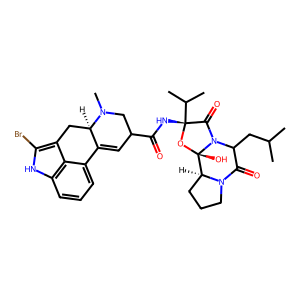

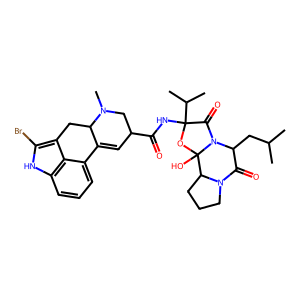

In [19]:
# from rdkit.Chem import Draw
# 
# def visualize_smiles(smiles_list, title):
#     mols = [Chem.MolFromSmiles(smi) for smi in smiles_list if smi]
#     for mol in mols:
#         display(Draw.MolToImage(mol, size=(300, 300)))
# 
# 
# 
# # Example: Visualize Pair 1
# pair_1_smiles = [
#     "CC(C)CC1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12",
#     "CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12"
# ]
# visualize_smiles(pair_1_smiles, ["Harmonized Web Original", "Harmonized Web Canonical"])

In [20]:
# from rdkit.Chem import inchi
# 
# def convert_to_inchi(smiles):
#     """
#     Convert a SMILES string to its InChI and InChIKey representations.
#     """
#     try:
#         mol = Chem.MolFromSmiles(smiles)
#         if mol:
#             mol_inchi = inchi.MolToInchi(mol)
#             inchikey = inchi.InchiToInchiKey(mol_inchi)
#             return mol_inchi, inchikey
#         else:
#             return None, None
#     except Exception as e:
#         print(f"Error converting SMILES '{smiles}' to InChI: {e}")
#         return None, None

In [21]:
# # Analyze mismatched pairs using InChI and InChIKey
# for i, (web_original, web_canonical) in enumerate(zip(web_original_mismatch, web_canonical_mismatch), start=1):
#     inchi_original, inchikey_original = convert_to_inchi(web_original)
#     inchi_canonical, inchikey_canonical = convert_to_inchi(web_canonical)
# 
#     print(f"\nPair {i}:")
#     print(f"  Web Original SMILES: {web_original}")
#     print(f"  Web Canonical SMILES: {web_canonical}")
#     print(f"  InChI Original: {inchi_original}")
#     print(f"  InChI Canonical: {inchi_canonical}")
#     print(f"  InChIKey Original: {inchikey_original}")
#     print(f"  InChIKey Canonical: {inchikey_canonical}")
# 
#     if inchikey_original == inchikey_canonical:
#         print("✅ InChIKey match: The molecules are identical.")
#     else:
#         print("❌ InChIKey mismatch: The molecules may differ.")


Pair 1:
  Web Original SMILES: [H][C@@]12CCCN1C(=O)[C@]([H])(CC(C)C)N1C(=O)[C@@](O[C@@]21O)(N=C(O)[C@@]1([H])CN(C)[C@]2([H])CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
  Web Canonical SMILES: CC(C)CC1N2C(=O)C(OC2(O)C2CCCN2C1=O)(N=C(O)C1CN(C)C2CC3=C(Br)NC4=CC=CC(=C34)C2=C1)C(C)C
  InChI Original: InChI=1S/C32H40BrN5O5/c1-16(2)12-24-29(40)37-11-7-10-25(37)32(42)38(24)30(41)31(43-32,17(3)4)35-28(39)18-13-20-19-8-6-9-22-26(19)21(27(33)34-22)14-23(20)36(5)15-18/h6,8-9,13,16-18,23-25,34,42H,7,10-12,14-15H2,1-5H3,(H,35,39)/t18-,23-,24+,25+,31-,32+/m1/s1
  InChI Canonical: InChI=1S/C32H40BrN5O5/c1-16(2)12-24-29(40)37-11-7-10-25(37)32(42)38(24)30(41)31(43-32,17(3)4)35-28(39)18-13-20-19-8-6-9-22-26(19)21(27(33)34-22)14-23(20)36(5)15-18/h6,8-9,13,16-18,23-25,34,42H,7,10-12,14-15H2,1-5H3,(H,35,39)
  InChIKey Original: OZVBMTJYIDMWIL-AYFBDAFISA-N
  InChIKey Canonical: OZVBMTJYIDMWIL-UHFFFAOYSA-N
❌ InChIKey mismatch: The molecules may differ.

Pair 2:
  Web Original SMILES: COC1=C(OC)C=C2C(=O)N=C(CSCC(=O)N

## Cononical mismatch

In [11]:
# Create mappings for web-derived SMILES
original_canonized_mapping = {}
for smi in canonical_smiles:
    try:
        canonical = MoleCule.from_smiles(smi).canonical_smiles
        original_canonized_mapping[canonical] = smi
    except:
        continue

web_canonical_mapping = {}
for smi in web_canonical_smiles:
    try:
        canonical = MoleCule.from_smiles(smi).canonical_smiles
        web_canonical_mapping[canonical] = smi
    except:
        continue
original_canonical_mismatch = []
web_canonical_mismatch = []
# Compare the mappings
print("\nDetailed Mismatch Analysis between Web Original and Web Canonical SMILES:")
for canonical_smi in original_canonized_mapping:
    original_canonized_smi = original_canonized_mapping.get(canonical_smi)
    web_canonical_smi_from_web_canonical = web_canonical_mapping.get(canonical_smi)
    
    if web_canonical_smi_from_web_canonical and original_canonized_smi != web_canonical_smi_from_web_canonical:
        original_canonical_mismatch.append(original_canonized_smi)
        web_canonical_mismatch.append(web_canonical_smi_from_web_canonical)
        print(f"Mismatch for canonical SMILES '{canonical_smi}':")
        print(f"  Original Canonical: {original_canonized_smi}")
        print(f"  Web Canonical: {web_canonical_smi_from_web_canonical}")


Detailed Mismatch Analysis between Web Original and Web Canonical SMILES:
Mismatch for canonical SMILES 'COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2':
  Original Canonical: COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2
  Web Canonical: COC1=C(OC)C=C2CN(CCC2=C1)C(=O)NC(CC(C)C)C(O)=O
Mismatch for canonical SMILES 'CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=O)O)ccc12':
  Original Canonical: CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=O)O)ccc12
  Web Canonical: CCCC1=CC(=O)OC2=C1C=CC(OC(C)C(=O)NC(CC1=CC=CC=C1)C(O)=O)=C2C
Mismatch for canonical SMILES 'CC(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(C=O)CCCN=C(N)N':
  Original Canonical: CC(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(C=O)CCCN=C(N)N
  Web Canonical: CC(C)CC(NC(C)=O)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C=O
Mismatch for canonical SMILES 'CN=C(N)NCCCC(N)C(=O)O':
  Original Canonical: CN=C(N)NCCCC(N)C(=O)O
  Web Canonical: CN=C(N)NCCCC(N)C(O)=O
Mismatch for canonical SMILES 'CC1COCCN1c1cc(-c2ccnn2C)c2ccnc(-c3ccn[nH]3)c2n1':
  Original Canonical

In [16]:
# Iterate over mismatched pairs
results = []
for i, (web_original, web_canonical) in enumerate(zip(canonical_smiles, web_canonical_smiles), start=1):
    tanimoto_score = calculate_tanimoto(web_original, web_canonical)
    results.append((i, web_original, web_canonical, tanimoto_score))

# Output results
df_results = pd.DataFrame(results, columns=["Pair Index", "Web Original SMILES", "Web Canonical SMILES", "Tanimoto Similarity"])

# Save or display results
print(df_results)
df_results.to_csv("tanimoto_similarity_results.csv", index=False)

    Pair Index                                Web Original SMILES  \
0            1        COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2   
1            2  CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc...   
2            3  CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=...   
3            4                     O=C1CN2Cc3c(ccc(Cl)c3Cl)N=C2N1   
4            5                CCN=C1Nc2ccc(Cl)cc2C(C)(c2ccccc2)O1   
..         ...                                                ...   
95          96        CC(C)C(NC(=O)Cc1ccc2c(c1)CCC(C)(C)O2)C(=O)O   
96          97      CC1Cc2ccccc2N1C(=O)Cc1nc(N2CCOCC2)cc(=O)[nH]1   
97          98  CCC(C)C(NC(=O)C(Cc1ccc(O)cc1)NC(=O)C(NC(=O)C(C...   
98          99  Cc1c(C(=O)NN2CCCCC2)nn(-c2ccc(Cl)cc2Cl)c1-c1cc...   
99         100               COc1ccc(Cc2nnc(N3CCOCC3)[nH]c2=O)cc1   

                                 Web Canonical SMILES  Tanimoto Similarity  
0   [H]N[C@@H](CO)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([...             0.209877  
1      COC1=C(OC)

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Canonicalize web_original_mismatch and web_canonical_mismatch
harmonized_web_original = [advanced_canonicalize(smi) for smi in canonical_smiles]
harmonized_web_canonical = [advanced_canonicalize(smi) for smi in web_canonical_smiles]

# Compare the harmonized SMILES
print("\nHarmonized Mismatch Analysis:")
for i, (original, canonical) in enumerate(zip(harmonized_web_original, harmonized_web_canonical), start=1):
    print(f"\nPair {i}:")
    print(f"  Harmonized Web Original: {original}")
    print(f"  Harmonized Web Canonical: {canonical}")
    if original == canonical:
        print("✅ Harmonized SMILES match.")
    else:
        print("❌ Harmonized SMILES do NOT match.")


Harmonized Mismatch Analysis:

Pair 1:
  Harmonized Web Original: COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2
  Harmonized Web Canonical: CCC(C)C(NC(=O)C(CCSC)NC(=O)C(N)CO)C(=O)NC(CC(C)C)C(=O)NC(CCC(=O)O)C(=O)NC(CO)C(=O)O
❌ Harmonized SMILES do NOT match.

Pair 2:
  Harmonized Web Original: CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12
  Harmonized Web Canonical: COc1cc2c(cc1OC)CN(C(=O)NC(CC(C)C)C(=O)O)CC2
❌ Harmonized SMILES do NOT match.

Pair 3:
  Harmonized Web Original: CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=O)O)ccc12
  Harmonized Web Canonical: CC(C)CC1C(=O)N2CCCC2C2(O)OC(NC(=O)C3C=C4c5cccc6[nH]c(Br)c(c56)CC4N(C)C3)(C(C)C)C(=O)N12
❌ Harmonized SMILES do NOT match.

Pair 4:
  Harmonized Web Original: Oc1cn2c(n1)Nc1ccc(Cl)c(Cl)c1C2
  Harmonized Web Canonical: CCCc1cc(=O)oc2c(C)c(OC(C)C(=O)NC(Cc3ccccc3)C(=O)O)ccc12
❌ Harmonized SMILES do NOT match.

Pair 5:
  Harmonized Web Original: CCN=C1Nc2ccc(Cl)cc2C(C)(c2ccccc2)O1
  Harmonized W

In [23]:
set(harmonized_web_original) == set(harmonized_web_canonical)

False

In [24]:
len(set(harmonized_web_original) & set(harmonized_web_canonical))

94

In [17]:
len(molecules)

15115

In [22]:
output_smiles = set()
for molecule in molecules:
    smiles = molecule.get('smiles')
    if smiles:
        output_smiles.add(smiles.strip())

In [23]:
len(output_smiles - set(canonical_smiles_list)) 

13352

In [24]:
canonical_smiles_list

['Cc1cc(N2CCN(c3ncnc(C4CC4)c3F)CC2)n2nccc2n1',
 'O=C(O)[C@H]1Cc2ccccc2CN1',
 'CC[C@@H](C)[C@H](NC(=O)[C@H](C)n1nnc2ccccc2c1=O)C(=O)O',
 'CCc1ccc(-c2nn(C)c(=O)c3c2CCCC3)cc1S(=O)(=O)N1CCC(C(N)=O)CC1',
 'CCOc1cc(N2CCC(O)CC2)ccc1Nc1ncc2c(n1)N(C1CCCC1)CCC(=O)N2C',
 'Cc1ccc(C(=O)Oc2ccc(C(CN(C)C)C3(O)CCCCC3)cc2)cc1',
 'COc1ccc(NC(=O)C(Cc2ccccc2)NC(=O)c2ccc(C)cc2)cc1',
 'C/C(=C(\\CCOC(=O)c1ccccc1)SC(=O)c1ccccc1)N(C=O)Cc1cnc(C)nc1N',
 'O=C(CSc1n[nH]c(-c2ccccc2Cl)n1)c1ccc(Br)cc1',
 'CCC(C)c1ccccc1OCC(O)CSc1ccccn1',
 'COCCOC(=O)c1c(N)n(CCc2ccc(OC)c(OC)c2)c2nc3ccccc3nc12',
 'O=C(Nc1cccc(NCc2ccncc2)c1)c1ccccc1Cl',
 'CCn1cc(-c2ccc(Cl)cc2)cc1C(=O)NCCOC',
 'CNc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1',
 'c1ccc(CNc2ncnc3nc[nH]c23)cc1',
 'Cc1cn(-c2ccc(NC(=O)Nc3ccccc3C)cc2)nn1',
 'O=C(CCc1ccccc1)NCc1nc(C2CCC(F)(F)CC2)no1',
 'COc1cccc(-c2cc(NCc3ccc4c(c3)OCO4)nc(N)n2)c1',
 'CCOC(=O)c1cnn2ccc(NC(=O)C3CC=CCC3)cc12',
 'CCOc1ccc(NC(=S)NNC(=S)NC2C=CCCC2)cc1',
 'CC#Cc1cncc(-c2ccc3c(c2)[C@]2(N=C(C)C

In [21]:
output_smiles

['OC1=CC=C(C=C1)C1(C(=O)NC2=CC=CC=C12)C1=CC=C(O)C=C1',
 'CC(C)CN1C2=C(NC=N2)C(=O)N(C)C1=O',
 'OC1=CC2=C(C=C1)C1(OC(=O)C3=CC=CC4=C3C1=CC=C4)C1=C(O2)C=C(O)C=C1',
 'COC(=O)C1(C)CCC(=O)C2(C)C1C(OC(C)=O)C(O)C1=CC(=CC(O)=C21)C(C)C',
 'ClC1=CC=CC(NNS(=O)(=O)C2=CC=C(Br)C=C2)=N1',
 'ClC1=C(NC2=NCCN2)C2=NSN=C2C=C1',
 'NC1=NC(N)=C(Cl)N=C1C(O)=NC(=N)NCC1=CC=CC=C1',
 'CCOCC1(COCC)CCC(CC1)C1=C(CN(C)CCNC)C=NN1',
 'COC1=C(OCC2=C(Cl)C=C(Cl)C=C2)C=CC(\\C=N/NC(=O)C2=C(C)N=C(N)S2)=C1',
 'OC(=O)C1=CC(NC2=NC=CC(NC3=CC(C(O)=O)=C(O)C=C3)=N2)=CC=C1',
 'FC1=CC=CC=C1N1C=C(C=N1)C(=O)NC1=CC(NC(=O)C=C)=C(F)C=C1',
 'NC(N)=NS(=O)(=O)C1=CC=C(N)C=C1',
 'CC(C)(O)CCC1=C(O)C=C(O)C2=C1OC(=C(O)C2=O)C1=CC=C(O)C=C1',
 'CCCOC1=C(C=C(C=C1)S(=O)(=O)NCCC1CCCN1C)C1=NC(=O)C2=C(N1)C(CCC)=NN2C',
 'C[C@H]1[C@H]2[C@H](CC3[C@@H]4CC[C@@H]5C[C@H](CC[C@]5(C)C4CC[C@]23C)O[C@@H]2O[C@H](CO)[C@@H](O[C@@H]3O[C@H](CO[C@@H]4OC[C@@H](O)[C@H](O)[C@H]4O)[C@@H](O[C@@H]4O[C@H](CO)[C@H](O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O)[C@H](O)[C@H]2O)O[C@]11CC[C@H](C

In [25]:
canonical_output = []
for smi in output_smiles:
    canonical_smi = MoleCule.from_smiles(smi).canonical_smiles
    canonical_output.append(canonical_smi)
canonical_output_set = set(canonical_output)

In [26]:
len(canonical_output_set)

13877

In [27]:
len(canonical_output_set - set(canonical_smiles_list)) 

548

In [ ]:
def merge_intermediate_results(intermediate_files):
    """
    Merges multiple intermediate JSON result files into a single dictionary.
    """
    merged_results = {}
    for file in intermediate_files:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                merged_results.update(data)
            print(f"Successfully merged results from {file}")
        except Exception as e:
            print(f"Error merging results from {file}: {e}")
    return merged_results

In [ ]:
# Merge all intermediate results
merged_results = merge_intermediate_results(intermediate_files)

In [ ]:
# Display the number of classified SMILES
classified_count = len(merged_results)
print(f"Total number of classified SMILES: {classified_count}")

# Convert the merged results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(merged_results, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Canonical_SMILES'}, inplace=True)

# Merge the classification results with the original SMILES DataFrame
annotated_df = pd.merge(smiles_df, results_df, on='Canonical_SMILES', how='left')

In [ ]:

# Handle unclassified SMILES
unclassified = annotated_df['superclass'].isnull().sum()
print(f"Number of SMILES without classification: {unclassified}")

# Fill NaN values with 'Unknown'
annotated_df[['superclass', 'class', 'subclass']] = annotated_df[['superclass', 'class', 'subclass']].fillna('Unknown')

# Save the annotated DataFrame to a TSV file
annotated_df.to_csv(final_output_path, sep='\t', index=False)

print(f"Annotated data has been saved to {final_output_path}")

In [8]:
def analyze_structure(data, level=0):
    """Recursively analyze and print the structure of JSON data."""
    if isinstance(data, dict):
        print(" " * level + f"Object with keys: {list(data.keys())}")
        for key, value in data.items():
            analyze_structure(value, level + 2)
    elif isinstance(data, list):
        print(" " * level + f"List of {len(data)} items")
        if len(data) > 0:
            analyze_structure(data[0], level + 2)  # Analyze the first item as representative
    else:
        print(" " * level + f"Value type: {type(data).__name__}")



In [9]:
# Load the JSON file
file_path = "/Users/macbook/CODE/PyClassyFire/data/intermediate_results/intermediate_1.json"  # Replace with your file's path
with open(file_path, "r") as file:
    json_data = json.load(file)

# Analyze the JSON structure
analyze_structure(json_data)

Object with keys: ['12021409']
  List of 100 items
    Object with keys: ['identifier', 'smiles', 'inchikey', 'kingdom', 'superclass', 'class', 'subclass', 'intermediate_nodes', 'direct_parent', 'alternative_parents', 'molecular_framework', 'substituents', 'description', 'external_descriptors', 'ancestors', 'predicted_chebi_terms', 'predicted_lipidmaps_terms', 'classification_version']
      Value type: str
      Value type: str
      Value type: str
      Object with keys: ['name', 'description', 'chemont_id', 'url']
        Value type: str
        Value type: str
        Value type: str
        Value type: str
      Object with keys: ['name', 'description', 'chemont_id', 'url']
        Value type: str
        Value type: str
        Value type: str
        Value type: str
      Object with keys: ['name', 'description', 'chemont_id', 'url']
        Value type: str
        Value type: str
        Value type: str
        Value type: str
      Object with keys: ['name', 'description', 'c

In [9]:
existing_smiles = load_existing_results(output_dir)
print(f"Already processed SMILES: {len(existing_smiles[0])}")

Already processed SMILES: 300


In [9]:
existing_smiles

({'C(C=CC1=CC=CC=C1)N1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1',
  'C(CN(CC1=CC=CC=N1)CC1=CC=CC=N1)N(CC1=CC=CC=N1)CC1=CC=CC=N1',
  'C(N1C=CN=C1)C1=CC(CN2C=CN=C2)=CC(CN2C=CN=C2)=C1',
  'C1=CC=C(C=C1)C1=C2C=CC3=C(C=CN=C3C2=NC=C1)C1=CC=CC=C1',
  'C1CN(CCN1)C1=CC=C(C=C1)C1=CN2N=CC(=C2N=C1)C1=CC=NC2=CC=CC=C12',
  'CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(CC12C)C1=CC=C(C=C1)N(C)C',
  'CC(=O)NCC1CN(C(=O)O1)C1=CC(F)=C(C=C1)N1CCN(CC1)C(=O)CO',
  'CC(C)(C)NC(=O)COC1=CC=C(CNC2=CC3=C(NC(=O)N3)C=C2)C=C1',
  'CC(C)(C)SC1=C(CC(C)(C)C(O)=O)N(CC2=CC=C(Cl)C=C2)C2=C1C=C(OCC1=NC3=CC=CC=C3C=C1)C=C2',
  'CC(C)(CC1CC2=CC=CC=C2C1)NCC(O)COC1=C(C=CC(CCC(O)=O)=C1)C#N',
  'CC(C)(OCc1nn(Cc2ccccc2)c2ccccc12)C(O)=O',
  'CC(C)C(=O)OCC1(CO1)C1=C(OC(=O)C(C)C)C=C(C)C=C1',
  'CC(C)C1=NOC(=N1)C1CCN(CC1)C1=C(C(NC2=C(F)C=C(C=C2)S(C)(=O)=O)=NC=N1)[N+]([O-])=O',
  'CC(C)CC(N1CC2=CC=CC=C2C1=O)C(=O)NC1=CC=CC2=C1C=CN2',
  'CC(C)OC1=CC=C(C=C1)C1=CN2N=CC(=C2N=C1)C1=CC=NC2=CC=CC=C12',
  'CC(C1CCC2C3CC=C4CC(CC(O)C4(C)C3CCC12C)OC1OC(COC2OC(CO)C(O

In [10]:
a = set(canonical_smiles_list) - set(existing_smiles[0])

In [11]:
len(a)

13971

In [12]:
b = set()
for smi in existing_smiles[0]:
    tmp = MoleCule.from_smiles(smi).canonical_smiles
    b.add(tmp)

In [13]:
c = set(canonical_smiles_list) - b

In [14]:
len(c)

13691

In [15]:
len(set(canonical_smiles_list))

13984

In [16]:
len(b)

300

In [22]:
b & c

set()

In [23]:
weird = c - set(canonical_smiles_list) 

In [24]:
weird

set()